In [ ]:
!wget https://www.di.ens.fr/willow/teaching/recvis18orig/assignment3/bird_dataset.zip
!unzip /content/bird_dataset.zip
!rm /content/bird_dataset.zip

In [ ]:
!cp -r bird_dataset cropped_bird_dataset

In [ ]:
!rm -r cropped_bird_dataset

In [ ]:
!pip install pyyaml==5.1
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

In [ ]:
import torch, torchvision
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from PIL import Image
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from torchvision import datasets

In [ ]:
models =["COCO-Detection/retinanet_R_101_FPN_3x.yaml","COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml","COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml","COCO-Detection/retinanet_R_50_FPN_3x.yaml"]

cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3 # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

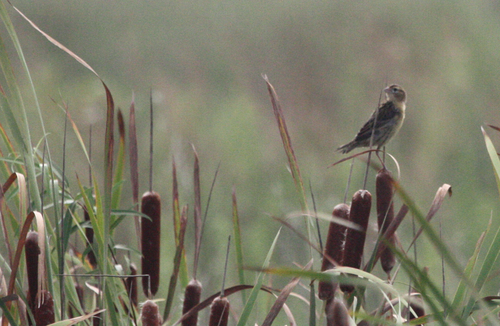

In [ ]:
im = cv2.imread("cropped_bird_dataset/test_images/mistery_category/fd5f28cd072603cb6e03c6e011808c0e.jpg")
cv2_imshow(im)

In [ ]:
outputs = predictor(im)

/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


In [ ]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)
print(outputs["instances"].scores)

tensor([14, 39], device='cuda:0')
Boxes(tensor([[335.1196,  84.5653, 406.6618, 171.5807],
        [320.8300, 196.5998, 368.1616, 271.7621]], device='cuda:0'))
tensor([0.9985, 0.7949], device='cuda:0')


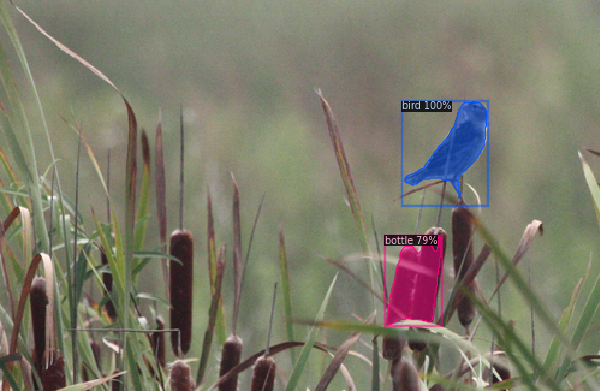

In [ ]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

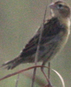

In [ ]:
top,left,bottom,right =  np.floor(outputs["instances"].pred_boxes.tensor.cpu().numpy()[0]).astype('int')
cv2_imshow(im[left:right,top:bottom])

In [ ]:
def detect_birds(predictor,im):
    '''Function that take a detection predictor and an image path
     and if he detect birds, return a bounding around the most confident one

     Parameters:
     ----------
        predictor: Detectron2 Object
            Object detector trained on COCO dataset
        img_path: Image
            Image we want to detect birds
    
    Return:
    -------
        most_confident_probas: float,
            Probas with the most confident of birds predictions. -1 if no bird found
        most_confident_bouding_box: int array,
            Coordinates of the most confident bounding box around the bird
            top,left,bottom,right format.

     '''
    outputs = predictor(im)
    if len(outputs["instances"].scores) != 0:
        probas = outputs["instances"].scores.cpu().numpy()
        mask_labels = (outputs["instances"].pred_classes.cpu().numpy()==14)
        probas[~mask_labels] = 0
        outputs["instances"].pred_boxes.tensor.cpu().numpy()
        most_confident = np.argmax(probas)
        most_confident_probas = probas[most_confident]
        most_confident_bouding_box = np.floor(outputs["instances"].pred_boxes.tensor.cpu().numpy()[most_confident]).astype('int')
        return most_confident_probas, most_confident_bouding_box
    else:
        return -1,[0,0,0,0]
def compute_best_predictor_box(predictors, im):
    '''
    For a list of predictors compute the more confident prediction for an image

    Parameters:
     ----------
        predictor: Detectron2 Object List
            Objects detectors trained on COCO dataset
        img_path: String
            Image we want to detect birds

    Return:
    -------
        max_proba: float,
            Probas with the most confident of predictors. -1 if no bird found in any detector
        max_bounding_box: int array,
            Coordinates of the most confident bounding box around the bird
            top,left,bottom,right format.
    '''
    max_proba = -1
    max_bounding_box = [0,0,0,0]
    for predictor in predictors:
        proba, bounding_box = detect_birds(predictor,im)
        if proba>max_proba:
            max_proba=proba
            max_bounding_box = bounding_box
    return max_proba, max_bounding_box
def list_of_predictors(config_list):
    '''
    Takes a config list and return a list of predictors\

    Parameter:
    ----------
        config_list: list,
            Config list where each item is a detectron2 config
    Return:
    ------
        predictors: list of Detectron2 Objects.
            List of predictors trained on Coco dataset
    '''
    predictors =[]
    for config in config_list:
        cfg = get_cfg()
        cfg.merge_from_file(model_zoo.get_config_file(config))
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3 
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config)
        predictor = DefaultPredictor(cfg)
        predictors.append(predictor)
    return predictors

In [ ]:
def crop_img(im,bbox):
    '''
    Crop the image acording to a bounding box. We adapt the bounding box to get a square crop and avoid distorsion. If image too small gets the biggest rectangle

    Parameters:
    ----------
        im: Image,
            Image we want to crop.
        bbox: array,
            Bounding box around which we are going to crop.

    Return:
    -------
        cropped: Image,
            Cropped image according to bounding box.
    '''
    left,top,right,bottom = bbox
    h,w = im.shape[0:2]
    max_dim = max(bottom-top,right-left)
    center_y = (top+bottom)
    center_x = (right+left)
    # top,left,bottom,right = max(int((center_y-max_dim)/2),0),max(int((center_x-max_dim)/2),0),min(int((center_y+max_dim)/2),h), min(int((center_x+max_dim)/2),w)
    cropped = im[top:bottom,left:right]
    return cropped

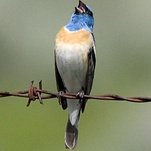

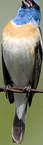

In [ ]:
im = cv2.imread("cropped_bird_dataset/test_images/mistery_category/1d901287dd62656c8089234dbb88d732.jpg")
cv2_imshow(im)
_,bbox=compute_best_predictor_box(predictors_segmentation,im)
cv2_imshow(crop_img(im,bbox))

In [ ]:
def crop_bird_dataset(path,predictors_segmentation,predictors_detection):
    '''
    For all images in subfolders of a path, we predict the best bounding box around a bird,
    crop according to the box and save the file at the same location with the cropped version

    WARNING: This overwrite your images, make sure to have a copy

    Parameters:
    -----------
        path: string,
        PAth to the
    '''
    for folder, sub_folder, files in os.walk(path):
        print(sub_folder)
        for id, file in enumerate(files):
            fullpath = os.path.join(folder, file)
            im = cv2.imread(fullpath)
            probas,bbox = compute_best_predictor_box(predictors_segmentation,im)
            if probas>0:
                cropped = crop_img(im,bbox)
                try: 
                  cv2.imwrite(fullpath,cropped)
                except:
                  print(f"Error saving cropped {fullpath}")
            else:
                probas,bbox = compute_best_predictor_box(predictors_detection,im)
                if probas>0:
                    cropped = crop_img(im,bbox)
                    try: 
                      cv2.imwrite(fullpath,cropped)
                    except:
                      print(f"Error saving cropped {fullpath}")
                else:
                    print(f" Predictors can't find birds in {fullpath}")


In [ ]:
config_list_segmentation= ['COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml']
config_list_detection =["COCO-Detection/retinanet_R_101_FPN_3x.yaml",]
predictors_segmentation = list_of_predictors(config_list_segmentation)
predictors_detection = list_of_predictors(config_list_detection)

Loading config /usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.
model_final_971ab9.pkl: 228MB [00:03, 72.1MB/s]                           


In [ ]:
crop_bird_dataset("cropped_bird_dataset/val_images",predictors_segmentation,predictors_detection)

['034.Gray_crowned_Rosy_Finch', '033.Yellow_billed_Cuckoo', '026.Bronzed_Cowbird', '015.Lazuli_Bunting', '031.Black_billed_Cuckoo', '019.Gray_Catbird', '023.Brandt_Cormorant', '014.Indigo_Bunting', '029.American_Crow', '011.Rusty_Blackbird', '010.Red_winged_Blackbird', '009.Brewer_Blackbird', '028.Brown_Creeper', '021.Eastern_Towhee', '020.Yellow_breasted_Chat', '016.Painted_Bunting', '012.Yellow_headed_Blackbird', '013.Bobolink', '004.Groove_billed_Ani', '030.Fish_Crow']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [ ]:
crop_bird_dataset("cropped_bird_dataset/train_images",predictors_segmentation,predictors_detection)

['034.Gray_crowned_Rosy_Finch', '033.Yellow_billed_Cuckoo', '026.Bronzed_Cowbird', '015.Lazuli_Bunting', '031.Black_billed_Cuckoo', '019.Gray_Catbird', '023.Brandt_Cormorant', '014.Indigo_Bunting', '029.American_Crow', '011.Rusty_Blackbird', '010.Red_winged_Blackbird', '009.Brewer_Blackbird', '028.Brown_Creeper', '021.Eastern_Towhee', '020.Yellow_breasted_Chat', '016.Painted_Bunting', '012.Yellow_headed_Blackbird', '013.Bobolink', '004.Groove_billed_Ani', '030.Fish_Crow']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [ ]:
crop_bird_dataset("cropped_bird_dataset/test_images",predictors_segmentation,predictors_detection)

['mistery_category']
[]


In [ ]:
!zip -r cropped_bird_dataset.zip cropped_bird_dataset/*

  adding: cropped_bird_dataset/test_images/ (stored 0%)
  adding: cropped_bird_dataset/test_images/mistery_category/ (stored 0%)
  adding: cropped_bird_dataset/test_images/mistery_category/d1c3426bbca3c249ea0ab1d0caa2e7d6.jpg (deflated 1%)
  adding: cropped_bird_dataset/test_images/mistery_category/2698cb89bccf6a5f4b29425f5f573f66.jpg (deflated 0%)
  adding: cropped_bird_dataset/test_images/mistery_category/3e619cc5303b8404c8ee5d595f87fb34.jpg (deflated 1%)
  adding: cropped_bird_dataset/test_images/mistery_category/958a765e4a60521e1dea9db1f03961e8.jpg (deflated 1%)
  adding: cropped_bird_dataset/test_images/mistery_category/c2c494a74bfb7ca6c211683b231ccf9c.jpg (deflated 1%)
  adding: cropped_bird_dataset/test_images/mistery_category/c2571a1237f1136dd5a32b67ee0d695f.jpg (deflated 0%)
  adding: cropped_bird_dataset/test_images/mistery_category/debdd05c4a5cfc1ea008e040ca64fc30.jpg (deflated 4%)
  adding: cropped_bird_dataset/test_images/mistery_category/08edd1314726785f6feddcce7854f881.j